# 定義欄

In [19]:
import xml.etree.ElementTree as ET 
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from IPython.display import display

#マスタデータのインポート
master = pd.read_csv(os.getcwd() + "/Resources/RugbyHub_master_data.csv",dtype=str)

#PLID,TEAMIDのインポート
psheets = ["PLID", "TID", "Venue"]
plid = pd.read_csv(os.getcwd()+"/Resources/plid_master.csv",dtype=str)
ptid = pd.read_excel(os.getcwd() +"/Resources/Japan Rugby League One Player ID.xlsx", sheet_name = psheets,dtype=str)
tid = pd.DataFrame(ptid["TID"])
venue = pd.DataFrame(ptid["Venue"])

def read_xml(FILEPATH):
    # XMLファイルを解析
    tree = ET.parse(FILEPATH) 

    # XMLを取得
    root = tree.getroot()
    df = pd.DataFrame(index=[],columns = ['ID','FXID','PLID','team_id','ps_timestamp','ps_endstamp','MatchTime','psID','period',
               'x_coord','y_coord','x_coord_end','y_coord_end','action','ActionType','Actionresult',
               'qualifier3','qualifier4','qualifier5','Metres','PlayNum','SetNum',
               'sequence_id','player_advantage','score_advantage','flag','advantage','assoc_player'])

    for action in root.iter('ActionRow'):
        s = pd.Series([action.get('ID'),action.get('FXID'),action.get('PLID'),action.get('team_id'),
                       action.get('ps_timestamp'),action.get('ps_endstamp'),action.get('MatchTime'),action.get('psID'),
                       action.get('period'),action.get('x_coord'),action.get('y_coord'),action.get('x_coord_end'),action.get('y_coord_end'),
                       action.get('action'),action.get('ActionType'),action.get('Actionresult'),action.get('qualifier3'),
                       action.get('qualifier4'),action.get('qualifier5'),action.get('Metres'),action.get('PlayNum'),action.get('SetNum'),
                       action.get('sequence_id'),action.get('player_advantage'),action.get('score_advantage'),action.get('flag'),
                       action.get('advantage'),action.get('assoc_player')], index = df.columns)
        df = df.append(s, ignore_index=True)

    df[['x_coord', 'y_coord','x_coord_end', 'y_coord_end']] = df[['x_coord', 'y_coord','x_coord_end', 'y_coord_end']].astype(int)

    df.qualifier3 = df.qualifier3.map(master.set_index('ID').Definition)
    df.qualifier4 = df.qualifier4.map(master.set_index('ID').Definition)
    df.qualifier5 = df.qualifier5.map(master.set_index('ID').Definition)
    df.Actionresult = df.Actionresult.map(master.set_index('ID').Definition)
    df.ActionType = df.ActionType.map(master.set_index('ID').Definition)
    df.action = df.action.map(master.set_index('ID').Definition)

    df.team_id = df.team_id.map(tid.set_index('team_id').team_name)
    df.PLID = df.PLID.map(plid.set_index('players_id').player_known_name)
#     print(df)
#     df.to_csv('/Users/isakakou/Desktop/933707_KUBOvNECG_advanced_superscout.csv', header=True, index=False)
    return df

def ruck_speed(df, TEAMNAME):

    dfaction = df.loc[(df['team_id'] == TEAMNAME)]

    dfaction = dfaction.loc[dfaction['action'] == 'Ruck']
    rspeed = ['0-1 Seconds','1-2 Seconds','2-3 Seconds','3-4 Seconds','4-5 Seconds','5-6 Seconds','6+ Seconds', "N/A Ruck Speed"]
    cl = ['y','m', 'c', 'r', 'g', 'b', (0,0.3,0.5), (0,0,0)]
    fig = plt.figure(figsize=(7, 10))
    ax = fig.add_subplot(1, 1,1)
    plt.xlim(0, 68)
    plt.ylim(0,100)

    a = pd.crosstab(dfaction['action'],dfaction['qualifier4'])
    a = a.reindex(columns=rspeed).fillna(0).astype(int)
    a.to_csv('/Users/isakakou/Desktop/'+TEAMNAME +' Ruck Speed.csv')
    print(a)

    #背景画像の設定
    fig.patch.set_facecolor('white')
    im = Image.open(os.getcwd()+"/Resources/FIELD_image.jpeg")
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    plt.imshow(im, extent=[*xlim, *ylim], aspect='auto', alpha=0.6)

    for i in range(len(rspeed)):
        r = dfaction.loc[dfaction['qualifier4'] == rspeed[i]]
        plt.scatter(r['y_coord'], r["x_coord"], label=rspeed[i] ,marker = 'D',color=cl[i], s=150)

    #ラベルの表示
    lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 12)
    plt.title(TEAMNAME)
    plt.gcf().subplots_adjust(wspace=4)
    plt.show()

def carry_meter(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    players = dfaction.drop_duplicates(subset=['PLID'],keep='first')
    player_list = players['PLID']
    player_list = player_list.reset_index(drop=True)
    carry_meter = pd.DataFrame()

    for i in range(len(player_list)):
        player_dfaction = dfaction.loc[dfaction['PLID'] == player_list[i]]
        carry = player_dfaction.loc[player_dfaction['action'] == 'Carry']
        carry_list = carry['Metres'].astype(int)
        s = pd.Series([player_list[i],carry_list.sum()], index = ['Name','Metres'])
        carry_meter = carry_meter.append(s, ignore_index=True)

    #carry_meter.to_csv('/Users/isakakou/Desktop/'+TEAMNAME +' Carry_Meter.csv')
    
    
def lineout(df,TEAMNAME):
    #チーム名指定でラインアウトデータ取得
    df = df.loc[(df['team_id'] == TEAMNAME)]

    dfaction = df.loc[df['action'] == 'Lineout Throw']
    b = pd.crosstab([dfaction['qualifier3'],dfaction['Actionresult']],dfaction['ActionType'],margins=True)
    b = b.reindex(columns=['Throw Front', 'Throw Middle', 'Throw Back', 'Throw 15m+'])

    plt.gcf().subplots_adjust(wspace=4)
    sns.heatmap(b,cmap='Blues', annot=True,annot_kws={'size':20})
    plt.show()
    plt.clf()
    
def kick(df, TEAMNAME):
    #Kickが入力された場合の処理-----
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'] == 'Kick']
    kicktypes = ['Bomb', 'Chip', 'Cross Pitch', 'Territorial', 'Low', 'Box', 'Touch Kick','Kick Error']
    kicks =  dfaction.loc[(dfaction['qualifier3'] =='Kick in Play') | (dfaction['qualifier3'] == 'Kick in Play (Own 22)')]

    cl = ['y','m', 'c', 'r', 'g', 'b', (0,0.3,0.5), (0,0,0)]
    fig = plt.figure(figsize=(7, 10))
    ax = fig.add_subplot(1, 1,1)
    plt.xlim(0, 70)
    plt.ylim(0,100)

    print(kicks[['PLID','MatchTime','ActionType','Actionresult']])
    for i in range(len(kicktypes)):
        plts = kicks.loc[kicks['ActionType']== kicktypes[i]]
        plt.quiver(plts['y_coord'], plts["x_coord"], (plts['y_coord_end']-plts['y_coord']), (plts["x_coord_end"]-plts['x_coord']), angles="xy", scale_units='xy',label= kicktypes[i], color = cl[i], scale=1,width=0.008, headwidth=5, headlength = 8, headaxislength = 7, pivot='tail')
    #Kickの処理ここまで------

    #背景画像の設定
    fig.patch.set_facecolor('white')
    im = Image.open(os.getcwd()+"/Resources/FIELD_image.jpeg")
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    plt.imshow(im, extent=[*xlim, *ylim], aspect='auto', alpha=0.6)

    #ラベルの表示
    lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 12)
    plt.title(TEAMNAME)
    plt.gcf().subplots_adjust(wspace=4)
    plt.show()

    #表を出力
    player_kicks = pd.crosstab([kicks['PLID'],kicks['ActionType']],kicks['Actionresult'])
    player_kicks.to_csv('/Users/isakakou/Desktop/'+TEAMNAME +' Kick Details.csv')
    display(player_kicks)
    
def twenty_two_entry(df,TEAMNAME):
    twenty_two_entry_outcome = ['22 Entry Outcome - Turnover','22 Entry Outcome - Try','22 Entry Outcome - Scrum Won','22 Entry Outcome - Penalty Won'
    ,'22 Entry Outcome - Penalty Goal Attempt','22 Entry Outcome - Penalty Conceded','22 Entry Outcome - Lineout Won','22 Entry Outcome - Kick Turnover'
    ,'22 Entry Outcome - Drop Goal']
    twenty_two_entry_points =['22 Entry Points - Try without Conversion','22 Entry Points - Try and Conversion'
    ,'22 Entry Points - Penalty Try','22 Entry Points - Penalty Goal','22 Entry Points - Drop Goal']
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'].str.contains('22 Entry',na=False)]
    display(dfaction[['action','ActionType','Actionresult',
               'qualifier3','qualifier4','qualifier5','PlayNum','SetNum']])

def possession_detail(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action']=='Possession']
    start_from_opp_22 = dfaction.loc[dfaction['x_coord'] >=77]
    display(start_from_opp_22[['team_id','action','ActionType','Actionresult','MatchTime','score_advantage']])
    
def tackle_table(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'] == 'Tackle']
    tackle_table = pd.crosstab([dfaction['ActionType'],dfaction['Actionresult']],dfaction['qualifier3'])
    display(tackle_table)
    
def maul_table(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    dfaction = dfaction.loc[dfaction['action'] == 'Maul']
    display(dfaction)
    maul_table = pd.crosstab(dfaction['Actionresult'],dfaction['qualifier5'])
    display(maul_table)
    
def attack_OOA(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    dfaction = dfaction.loc[dfaction['qualifier4'] =='Attacking OOA']
    display(dfaction[['PLID', 'ActionType','Actionresult','qualifier3','qualifier4','qualifier5']])
    attack_OOA_table = pd.crosstab(dfaction['PLID'],[dfaction['Actionresult'],dfaction['ActionType']])
    display(attack_OOA_table)
    attack_OOA_table.to_excel('/Users/isakakou/Desktop/'+TEAMNAME +' Attacking Ruck OOA.xlsx')
#     plt.gcf().subplots_adjust(wspace=4)
#     sns.heatmap(attack_OOA_table,cmap='Blues', annot=True,annot_kws={'size':20})
#     plt.rcParams["figure.figsize"] = (10,30)
#     plt.show()

def try_detail(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    try_set = dfaction.loc[dfaction['action'] == 'Try']
    try_set_list = try_set['SetNum']
    try_set_list = try_set_list.reset_index(drop=True)
    try_datas = pd.DataFrame()
    for i in range(len(try_set_list)):
        try_data = dfaction.loc[dfaction['SetNum'] == try_set_list[i]]
        try_datas = try_datas.append(try_data, ignore_index=True)
    display(try_datas[['PLID', 'action','ActionType','Actionresult','qualifier3','qualifier4','qualifier5','PlayNum','MatchTime']])
    
def get_opponent(df, TEAMNAME):
    return df.loc[df['team_id'] != TEAMNAME].team_id[0]


# TODO 起点によって実際のPossessionと定義上のPossessionでチームが異なる問題に対処する
def plot_rucks_per_possession(df, TEAMNAME):
    start_of_possessions = ['Restart Return', '50m Restart Retained','22m Restart','22m Restart Retained',
                            'Free Kick', 'Kick Return', 'Turnover Won','Lineout', 'Lineout Steal', 'Scrum',
                            'Scrum Steal', 'Tap Pen', 'Goal Line Restart', 'Goal Line Restart Retained']
    cmap = plt.get_cmap("jet")
    for i in range(len(start_of_possessions)):
        l=1
        fig = plt.figure(figsize=(7, 10))
        ax = fig.add_subplot(1, 1,1)
        plt.xlim(0, 68)
        plt.ylim(0,100)
        #背景画像の設定
        fig.patch.set_facecolor('white')
        im = Image.open(os.getcwd()+"/Resources/FIELD_image.jpeg")
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        plt.imshow(im, extent=[*xlim, *ylim], aspect='auto', alpha=0.6)
#         TODO 50m, 22m, Goal LineでのRestartを区別する(直前のRestart KickのActionTypeを取得する)
        if (start_of_possessions[i] in ['Turnover Won','Tap Pen','Kick Return']):
            plts = df.loc[((df['action'] == 'Possession')&(df['ActionType'] == start_of_possessions[i]))&(df['team_id'] == TEAMNAME)]
        else:
            plts = df.loc[(((df['action'] == start_of_possessions[i])|(df['ActionType'] == start_of_possessions[i]))&(df['team_id'] == TEAMNAME))]
#         else:
#         plts = df.loc[(df['action'] == start_of_possessions[i])&(df['team_id'] == TEAMNAME)].reset_index()
        plt.scatter(plts['y_coord'], plts["x_coord"] ,marker = 'D',s=150, color='red',zorder=2)
        for sn in plts.SetNum:
            if (start_of_possessions[i] in ['Turnover Won','Tap Pen','Kick Return']):
                start_of_set = df.loc[(df['action'] == 'Possession')&(df['ActionType'] == start_of_possessions[i])&(df['team_id'] == TEAMNAME)&(df['SetNum'] == sn)]
            else:
                start_of_set = df.loc[((df['action'] == start_of_possessions[i])|(df['ActionType'] == start_of_possessions[i]))&(df['SetNum'] == sn)]
            sets = df.loc[(df['SetNum'] == sn) & (df['action'] == 'Ruck')&(df['team_id'] == TEAMNAME)]
            sets = pd.concat([start_of_set,sets])
            x = sets['y_coord']
            y = sets["x_coord"]
            plt.plot(x, y,lw = 2,marker = 'o',color = cmap(l), markersize = 10,zorder=1)
            l=l+14
        # グラフタイトル
        plt.title('Rucks of ' + TEAMNAME +' (Start:'+ start_of_possessions[i] + ')', fontsize=18)
        # 散布図表示
        plt.gcf().subplots_adjust(wspace=4)
        plt.show()
        plt.clf()
        
def tackle_detail(df, TEAMNAME):
    dfaction = df.loc[(df['team_id']==TEAMNAME) &(df['action']=='Tackle')]
    display(dfaction[['action','ActionType','Actionresult','qualifier3','qualifier4','qualifier5']])
    tackle = pd.crosstab([dfaction['PLID'],dfaction['ActionType']],dfaction['Actionresult'])
    tackle_result = pd.crosstab(dfaction['PLID'],dfaction['Actionresult'])
    tackle_result_discriptor = dfaction['Actionresult'].drop_duplicates()
    fig = plt.figure(dpi=200,figsize=(16, 9))
    ax = fig.add_subplot(111)
    tackle_bar_graph = tackle_result.plot.barh(stacked=True,ax=ax)
    plt.legend(tackle_result_discriptor, loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

,action,ActionType,Actionresult,qualifier3,qualifier4,qualifier5
6,Tackle,Chase Tackle,Complete,None,Neutral Tackle,None
8,Tackle,Chase Tackle,Complete,Assist,Neutral Tackle,None
94,Tackle,Line Tackle,Complete,None,Neutral Tackle,None
95,Tackle,Line Tackle,Complete,None,Neutral Tackle,None
317,Tackle,Line Tackle,Complete,None,Neutral Tackle,None
...,...,...,...,...,...,...
3109,Tackle,Line Tackle,Passive,None,Ineffective Tackle,None
3110,Tackle,Line Tackle,Passive,None,Ineffective Tackle,None
3119,Tackle,Guard Tackle,Missed,None,Ineffective Tackle,None
3122,Tackle,Guard Tackle,Passive,None,Ineffective Tackle,None


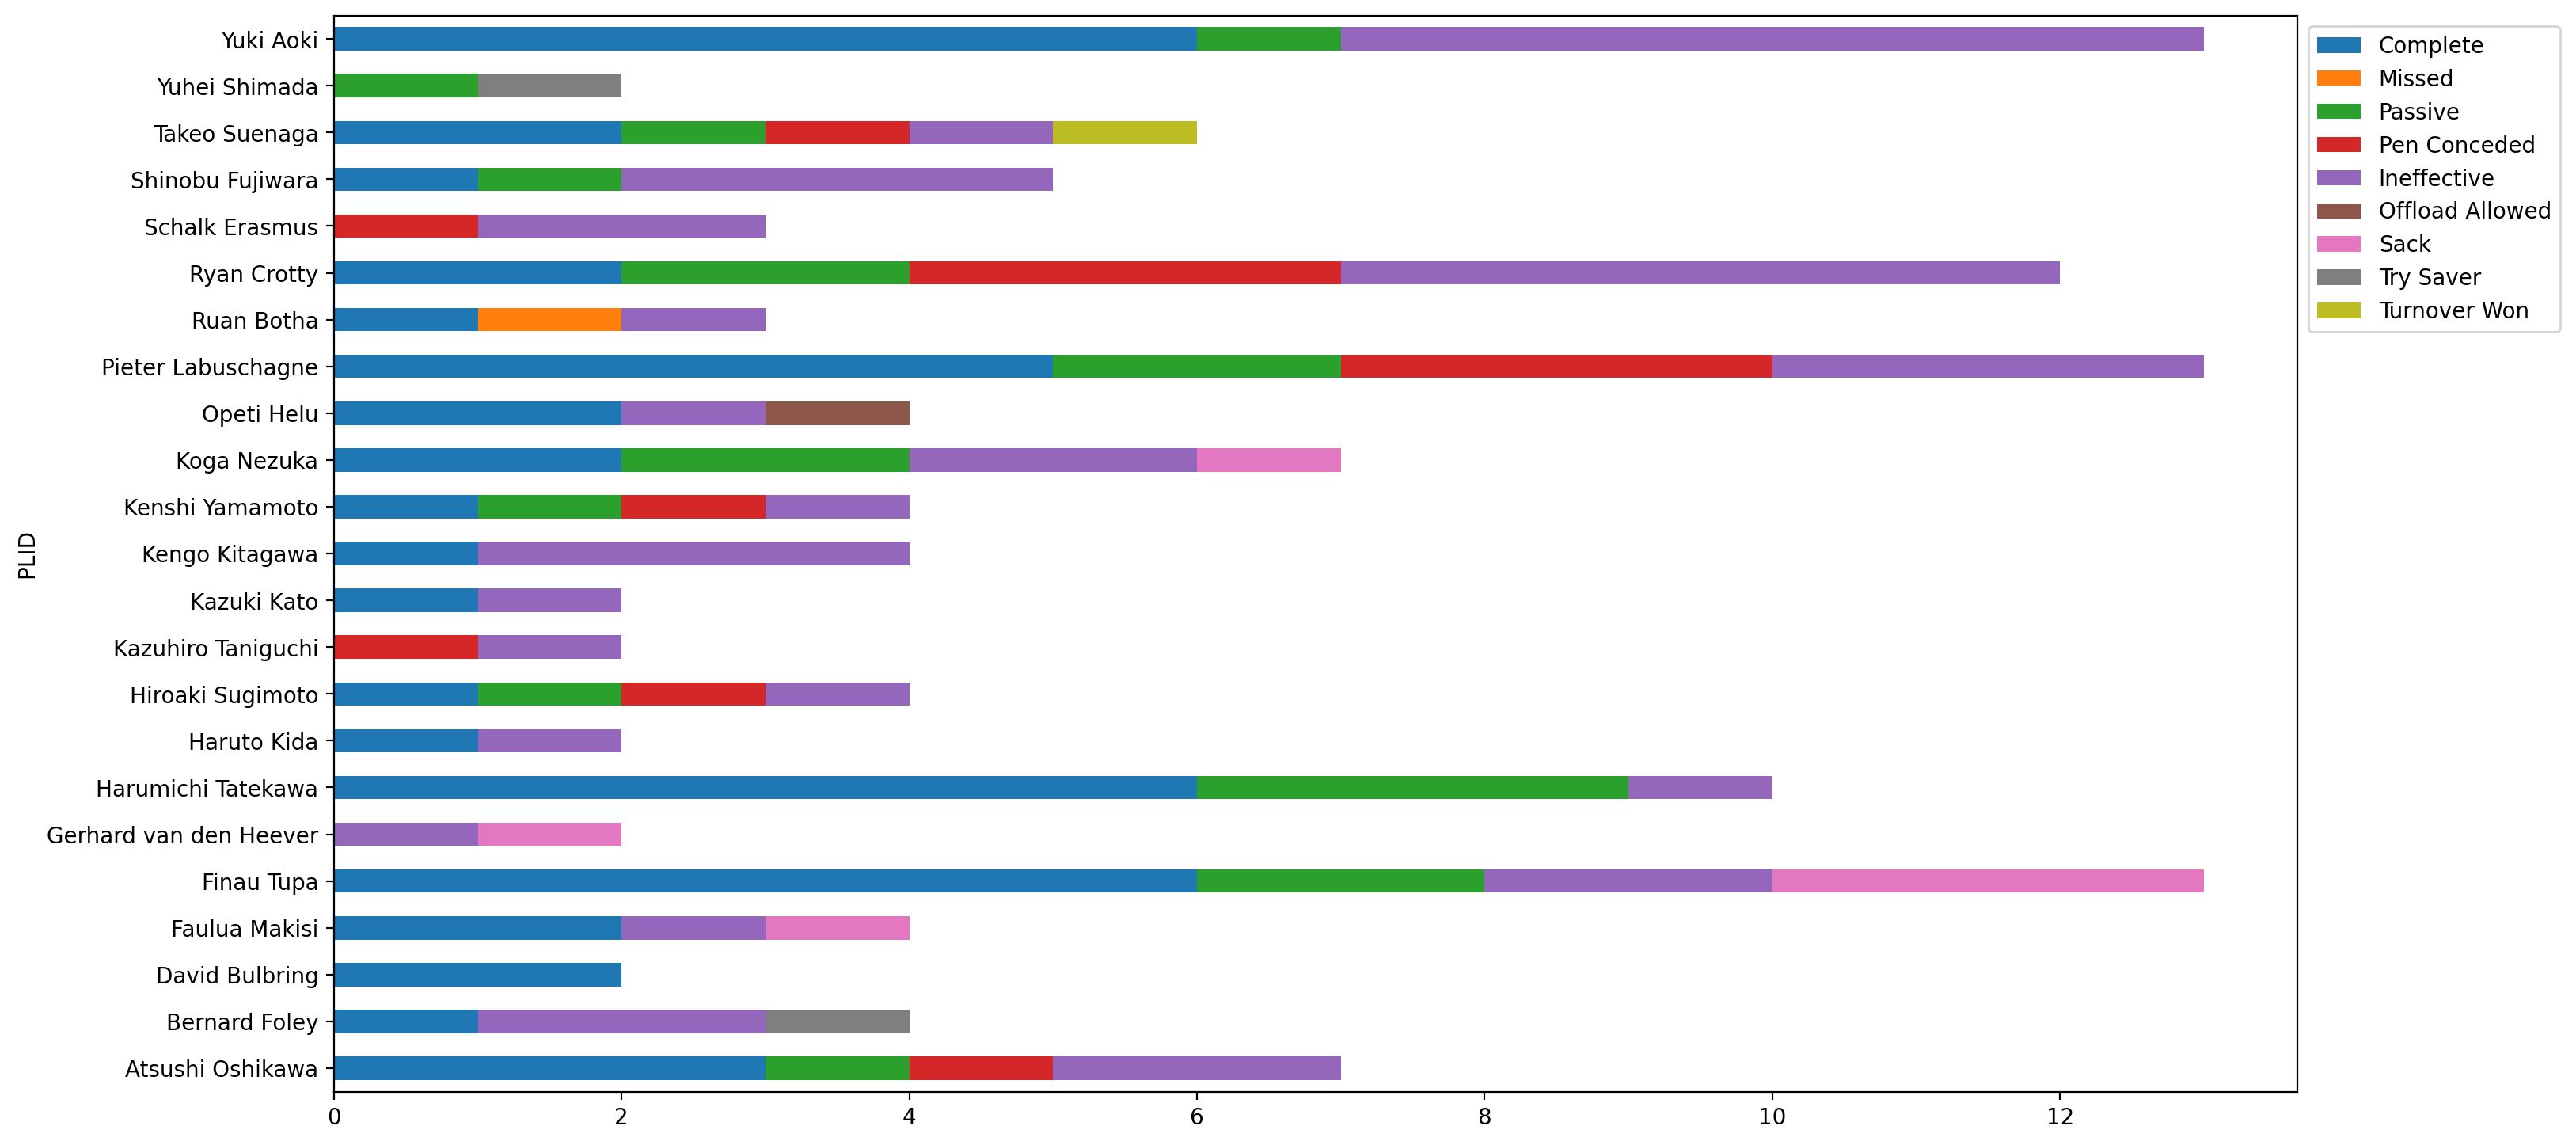

In [20]:
FILEPATH = '/Users/isakakou/Desktop/933707_KUBOvNECG_advanced_superscout.xml'
TEAMNAME = 'Kubota Spears'
df = read_xml(FILEPATH)
# kick(df,TEAMNAME)
# Kubota Spears
# Green Rockets Tokatsu
#ruck_speed(df, TEAMNAME)
# carry_meter(df, TEAMNAME)
# lineout(df,TEAMNAME)
# twenty_two_entry(df,TEAMNAME)
# possession_detail(df, TEAMNAME)
#tackle_table(df, TEAMNAME)
# attack_OOA(df,TEAMNAME)
# get_opponent(df, TEAMNAME)
# try_detail(df, get_opponent(df, TEAMNAME))
#plot_rucks_per_possession(df,TEAMNAME)
tackle_detail(df, TEAMNAME)